In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [373]:
%matplotlib notebook

In [2]:
# Importing data
batch1 = pd.read_parquet('../batches_train/batch_1_repartitions/part.0.parquet')
sensor_geom = pd.read_csv('../sensor_geometry.csv')

In [3]:
# Import meta data
meta = pd.read_parquet('../batches_train/train_meta.parquet/')

### Learning PCA (example)

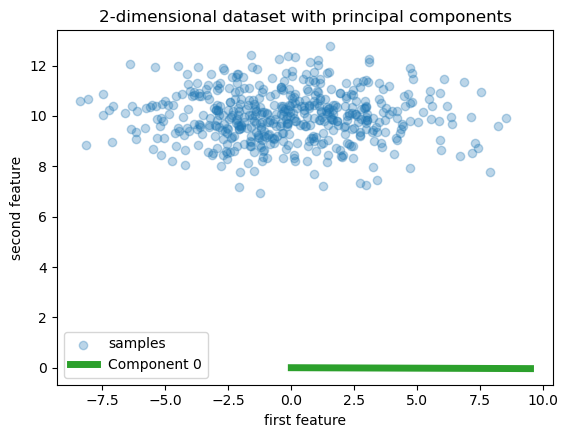

In [4]:
rng = np.random.RandomState(0)
n_samples = 500 
cov = [[10,0], [0,1]]
X = rng.multivariate_normal(mean=[0, 10], cov=cov, size=n_samples)
pca = PCA(n_components=1).fit(X)

plt.figure()

plt.scatter(X[:,0], X[:,1], alpha=0.3, label='samples')
for i, (comp,var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp*var
    plt.plot([0,comp[0]],
             [0,comp[1]],
             label=f'Component {i}',
             linewidth=5,
             color=f'C{i + 2}')
    
plt.gca().set(
    aspect = "equal",
    title='2-dimensional dataset with principal components',
    xlabel='first feature',
    ylabel='second feature'
)
plt.legend()
    
plt.show()

### PCA for the neutrinos

In [5]:
# Make a function that outputs (x,y,z) for a sensor_id input
def id_to_xyz(sen):
    row = tuple(sensor_geom.loc[sen][1:4])
    return row

In [6]:
# This function does pca to find the line of best fit
# given an event. An event is assumed to be a DataFrame
def direction_linear_fit(event):
    event = event[event.auxiliary==False]
    coords = [id_to_xyz(sen) for sen in event.sensor_id]

    pca = PCA(n_components=1)
    pca.fit(coords)
    
    dir_cartesian = pca.components_
    x = dir_cartesian[0,0]
    y = dir_cartesian[0,1]
    z = dir_cartesian[0,2]
    d1 = np.array((x,y,z))
    
    # We need to check if we need d1 or -d1 (=d2)
    first_pulse = np.array(id_to_xyz(event.iloc[0].sensor_id))
    last_pulse = np.array(id_to_xyz(event.iloc[-1].sensor_id))
    
    dir_of_origin = first_pulse - last_pulse
    
    inprod = np.dot(dir_of_origin,np.array(d1))

    if inprod > 0:
        d = d1
    else:
        d = -d1
    
    az = np.arctan2(d[1],d[0])
    
    if d[2] > 1.0:
        ze = 0
    elif d[2] < -1.0:
        ze = np.pi
    else:
        ze = np.arccos(d[2])
        
    return (az, ze)

In [7]:
event_ids = list(set(batch1.index))

In [10]:
N = 1000
test_indices = [event_ids[i] for i in range(0,N)]

meta_subset = meta[meta.event_id.isin(test_indices)]
batch1_subset = batch1.loc[test_indices]

In [12]:
preds = []
trues = []

count = 0
for index in test_indices:
    count = count + 1
    if count % 100 == 0:
        print("Testing..." + str(count), "complete")
    preds.append(direction_linear_fit(batch1_subset.loc[index]))
    
    ev = meta_subset[meta_subset.event_id==index]
    trues.append((ev.azimuth.values[0], ev.zenith.values[0]))

Testing...100 complete
Testing...200 complete
Testing...300 complete
Testing...400 complete
Testing...500 complete
Testing...600 complete
Testing...700 complete
Testing...800 complete
Testing...900 complete
Testing...1000 complete


In [13]:
def mse(A, B):
    D = np.zeros(A.shape)
    for i in range(0, D.shape[0]):
        D[i,0] = min(np.abs(A[i,0] - B[i,0]),
                     np.abs(A[i,0] - B[i,0] - 2*np.pi),
                     np.abs(A[i,0] - B[i,0] + 2*np.pi))
        D[i,1] = min(np.abs(A[i,1] - B[i,1]),
                     np.abs(A[i,1] - B[i,1] - np.pi),
                     np.abs(A[i,1] - B[i,1] - np.pi))
    return (np.square(D)).mean(axis=0)

In [14]:
A1 = np.array(preds)
B1 = np.array(trues)

In [15]:
mse(A1, B1)

array([2.71384493, 1.03836671])

The MSE on 1,000 examples is (2.71, 1.04) radians (azimuth error, zenith error). So, a little less than 180 degrees azimuth-ally, and about 60 degrees error zenith-ally. 